# Finite-Size Scaling method by neural network
The finite-size scaling (FSS) method is a powerful tool for getting universal information of critical phenomena. It estimates universal information from observables of critical phenomena at finite-size systems. In this document, we will introduce a FSS method based on a neural network (NN).

## Finite-size scaling law of a critical phase transition
The finite-size scaling (FSS) law describes the observables of critical phenomena in a finite-size system. It is written as
$$
A(L, T) = L^{-c_2} f[(T-T_c)L^{c_1}],
$$
where T is a temperature, L is a system size, A is observable, and $f[]$ is a scaling function. $T_c$ is a critical temperature, and $c_1$ and $c_2$ are critical exponents. We want to find these parameters to describe observables. If we introduce new variables as
\begin{align*}
X &= (T-T_c)L^{c_1},\\
Y &= A/L^{-c_2} = A L^{c_2},
\end{align*}
then the FSS law is
$$
Y = f[X].
$$
In usual, we write $c_1 = 1/\nu$. The $\nu$ is a critical exponent of a correlation length as
$$
\xi \propto (T-T_c)^{-\nu}.
$$

## Modeling a scaling function by NN
Although the scaling function is unclear in the FSS law, we model it in a neural network (NN) as $y=f(x)$. In the following, we use a feed-forward NN with two intermediate layers.

We consider observables in the FSS law as stochastic variables as
$$
Y \approx f(X) \pm E
\ \Rightarrow \ Y \approx N[ f(X), E^2]
$$
where $E$ is (an error of A) $\times L^{c_2}$. We optimize parameters $T_c, c_1, c_2$ and parameters of NN to maximize the likelihood.

## The Ising model on a square lattice
For example, we will try to do a FSS analysis for the two-dimensional Ising model on a square lattice.

The Hamiltonian $H$ of the Ising model is 
$$
H=-\sum_{\langle ij \rangle} \sigma_i \sigma_j,
$$
where $\sigma$ is an Ising variable ($\pm 1$) and $\langle ij \rangle$ is a pair of nearest neighbor sites on a square lattice.

The partition function $Z$ is
$$
Z = \sum_{\vec{\sigma}} \exp(-H/T),
$$
where $T$ is a temperature.
The magnetization $M$ is
$$
M = \sum_i \sigma_i  / L^2,
$$
where $L$ is a system size. This is an order parameter of the Ising phase transition.
The susceptibility $\chi$ is
$$
\chi = \langle M^2 \rangle.
$$

The two-dimensional Ising model has a critical phase transition at a critical temperature.
At the high temperatures, there is no order, and the averaged order parameter is zero. But, the order parameter continuously appears from a critical temperature. Below the critical temperature, the order parameter is finite. In particular, there is an exact solution of the square Ising model by Onsager (1944). Thus, the two-dimensional Ising model is the first non-trivial solvable model of a critical phase transition.

In the case of the square Ising model, the critical temperature $T_c$ is $\frac{1}{2} \log[1+\sqrt{2}]$.
The critical exponents $c_1$ and $c_2$ of the susceptibility $\chi$ are
\begin{align*}
&c_1 = 1/\nu = 1,\\
&c_2 = -\frac{\gamma}{\nu} = -\frac{7}{4}.
\end{align*}


In [1]:
import math
# Critical temperature of the square Ising model
tc_true = 0.5 * math.log(1+math.sqrt(2))
# For the susceptibility
c1_true, c2_true = (1.0, -1.75)

## Doing a FSS analysis by NN

### Preparation
The following modules are necessary.

In [2]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

The following are special modules for doing the FSS method by the NN.

In [3]:
import sys, os
sys.path.append(os.path.abspath(".."))
import fss_torch


We first declare the dataset and transformer classes.

### Dataset class
The dataset class stores the data of susceptibility. Each line of the data file consists of four values (system size, temperature, observable, statistical error). All data are automatically rescaled to do a finite-size scaling. In particular, the temperature is also transformed to a new scale. The two functions are prepared as "transform_t" and "inv_transform_t" in the dataset class.

In [4]:
dataset = fss_torch.fss.Dataset.fromFile(fname="./Data/Ising2D/ising-square-X.dat")


### Transformer class
The transformer class defines the transformation of four variables to the new variables (X, Y, E). It needs the initial values of a critical temperature, $c_1$, and $c_2$. The $T_c$ should be inversely transformed to an original scale by "inv_transform_t" function in the dataset class.

In [5]:
rtc, rc1, rc2 = (0.98, 0.9, 0.9)
initial_values = [dataset.transform_t(tc_true * rtc), c1_true * rc1, c2_true * rc2]
transform = fss_torch.fss.Transform(initial_values)

### NN Model
We define the NN model of a scaling function. Here, the number of neurons in intermediate layers is 50.

In [6]:
model = fss_torch.nsa_util.MLP(hidden_sizes=[50, 50])

### Optimizer 
We set the parameters of the NN model in an optimizer. The parameters of the transformer are also added in the optimizer.

In [7]:
optimizer = optim.Adam(model.parameters())
optimizer.add_param_group({"params": transform.parameters(), "lr": 0.01})

### Optimizing all paramters
The optimization steps are
1. transform original values to (X, Y, E) in a scaling function.
2. calculate a loss function by the NN model.
3. update all parameters.

In [8]:
losses = []
results = []
loss_fn = torch.nn.GaussianNLLLoss()
for epoch in range(5000):
    optimizer.zero_grad()
    new_data = transform(dataset.data)
    X = fss_torch.nsa_util.get_column(new_data, 0)
    Y = fss_torch.nsa_util.get_column(new_data, 1)
    E = fss_torch.nsa_util.get_column(new_data, 2)
    loss = loss_fn(model(X), Y, E * E)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    results.append([dataset.inv_transform_t(transform.tc), transform.c1, transform.c2])

We check results of $T_c$, $c_1$ and $c_2$.

In [9]:
tc_results, c1_results, c2_results = (dataset.inv_transform_t(transform.tc), transform.c1, transform.c2)
print("Exact values : Tc = {}, c1 = {}, c2 = {}".format(tc_true, c1_true, c2_true))
print("Results of FSS : Tc = {}, c1 = {}, c2 = {}".format(tc_results, c1_results, c2_results))

Exact values : Tc = 0.44068679350977147, c1 = 1.0, c2 = -1.75
Results of FSS : Tc = 0.44072753076907745, c1 = 0.9660908579826355, c2 = -1.7375082969665527


We plot a scaling function, loss and optimization process of paramters $T_c$ and $c_2$.

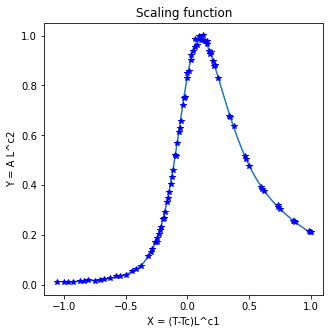

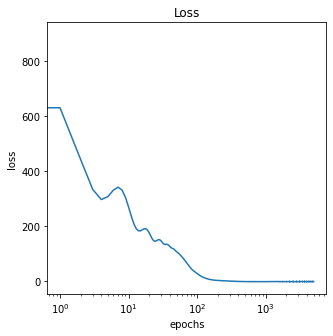

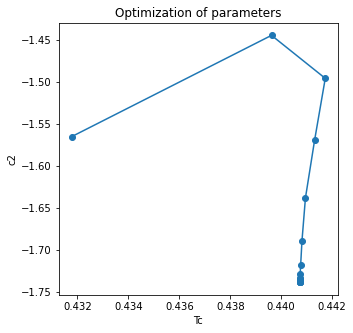

In [10]:
fig, ax0 = plt.subplots(figsize=(5,5))
new_data = transform(dataset.data)
X, Y, E = new_data[:,0], new_data[:,1], new_data[:,2]
test_x = torch.linspace(-1, 1, 51).view(-1,1)
observed_pred = model(test_x)
ax0.set_title("Scaling function")
ax0.set_xlabel("X = (T-Tc)L^c1")
ax0.set_ylabel("Y = A L^c2")
ax0.plot(test_x, observed_pred.detach().numpy())
ax0.plot(X.detach().numpy(), Y.detach().numpy(), 'b*')

fig, ax1 = plt.subplots(figsize=(5,5))
ax1.set_title("Loss")
ax1.set_xlabel("epochs")
ax1.set_ylabel("loss")
ax1.set_xscale("log")
ax1.plot(losses)

fig, ax2 = plt.subplots(figsize=(5,5))
X = [r[0] for r in results[::100]]
Y = [r[2] for r in results[::100]]
ax2.set_title("Optimization of parameters")
ax2.set_xlabel("Tc")
ax2.set_ylabel("c2")
ax2.plot(X, Y, marker="o")